# To find out more about this Kaggle competition : [Click here](https://www.kaggle.com/c/nlp-getting-started)


# 1. Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Kaggle - Natural Language Processing with Disaster Tweets/')

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install tweet-preprocessor
!pip install sentencepiece
!pip install seaborn --upgrade
print("Seaborn version : " + str(sns.__version__))

import preprocessor as p
import string
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB

import tokenization
import tensorflow_hub as hub
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

pd.options.display.float_format = '{:,.1f}'.format

# 2. Load data

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/Kaggle - Natural Language Processing with Disaster Tweets/nlp-getting-started/"

train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
sample_submission = pd.read_csv(path+"sample_submission.csv")

# 3. Date exploration

### 3.1 Quick view

In [7]:
train.sample(5) #with random seed

,id,keyword,location,text,target
2423,3483,derailed,"Kalamazoo, Michigan",three episodes left the end is nigh,0
3124,4488,electrocuted,Karachi Pakistan,#pakistan#news# NANKANA SAHIB City News: Elect...,1
641,930,blaze,NaN,I've been by the pool all day #raisinfingers,0
2462,3530,derailment,New Delhi,Suresh Prabhu calls Harda derailment a natural...,1
1492,2150,catastrophe,All around the world baby,@mark_argent I haven't watched that one yet. J...,0


### 3.2 Table size

In [16]:
print('Size of train dataset : ' +str(train.shape))
print('Size of test dataset : ' +str(test.shape))

Size of train dataset : (7613, 5)
Size of test dataset : (3263, 4)


### 3.3 Missing data

In [17]:
print('Number of NAN values in train dataset columns:')
print(train.isna().sum())

Number of NAN values in train dataset columns:
id          0   
keyword     61  
location    2533
text        0   
target      0   
dtype: int64


In [18]:
print('Number of NAN values in test dataset columns:')
print(test.isna().sum())

Number of NAN values in test dataset columns:
id          0   
keyword     26  
location    1105
text        0   
dtype: int64


### 3.4 Number of tweets about disasters vs not about disasters

Target column distribution in train dataset:
0    4342
1    3271
Name: target, dtype: int64


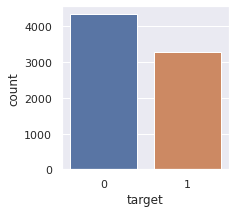

In [19]:
print('Target column distribution in train dataset:')
print(train.target.value_counts())
sns.set(rc={'figure.figsize':(3,3)})
sns.countplot(data=train,x = 'target')

### 3.5 Twenty most frequent keywords in train dataset

In [20]:
df_train_positive = train[train['target'] == 1]
df_train_negative = train[train['target'] == 0]

Text(0.5, 1.0, 'Tweets not about disastors')

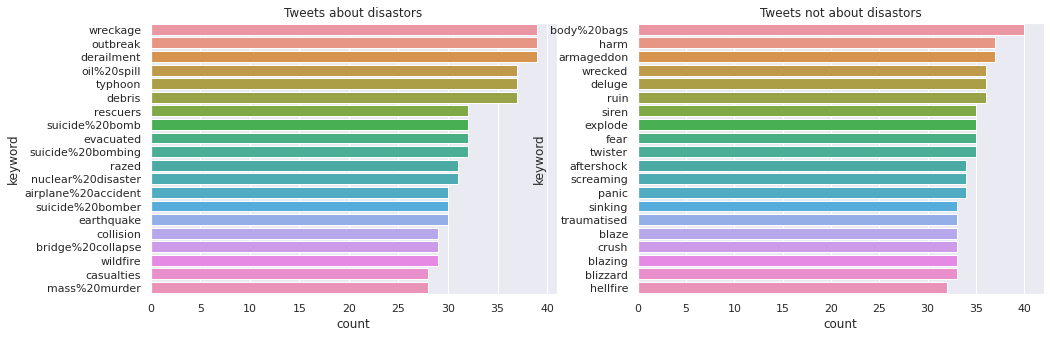

In [21]:
sns.set(rc={'figure.figsize':(16,5)})
fig, axs = plt.subplots(ncols=2)
sns.countplot(data = df_train_positive, y = 'keyword', order=df_train_positive.keyword.value_counts().iloc[:20].index, ax=axs[0]).set_title('Tweets about disastors')
sns.countplot(data = df_train_negative, y = 'keyword', order=df_train_negative.keyword.value_counts().iloc[:20].index, ax=axs[1]).set_title('Tweets not about disastors')

### 3.6 Twenty most commun locations in train dataset

Text(0.5, 1.0, 'Tweets not about disastors')

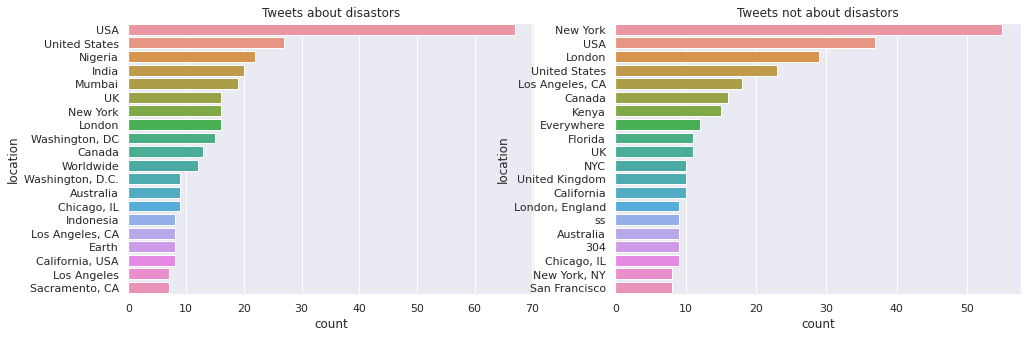

In [22]:
sns.set(rc={'figure.figsize':(16,5)})
fig, axs = plt.subplots(ncols=2)
sns.countplot(data = df_train_positive, y = 'location', order=df_train_positive.location.value_counts().iloc[:20].index, ax=axs[0]).set_title('Tweets about disastors')
sns.countplot(data = df_train_negative, y = 'location', order=df_train_negative.location.value_counts().iloc[:20].index, ax=axs[1]).set_title('Tweets not about disastors')

In [23]:
print('Number of different locations in train data : ' + str(train.location.nunique()))

Number of different locations in train data : 3341


We have a lot of differently typed and often specific tweet locations. If we wanted to use them, we would have to structure them so that later on our algorithm can make a better use of this data. 
In the graphs above, we can see that :
- tweets are unevenly distributed by locations and some countries, like the US, appear a lot more frequently in our dataset
- disaster announcing tweets vs. not disaster announcing tweets can have the same locations (especially if we transform these specific locations into only country labels) 
- overall, we have 3341 different locations. Cleaning and organizing this data would probably take too much time compared to the value that we can get out of it. 
- Probably we would have to frequently work with locations in the test dataset that didn't appear in our train dataset.

For these reasons, we will choose to not include the 'location' column into our model, even if its performance will be a "little" worse. 

# 4. Creating additional data

### 4.1 Add some statistics about the tweets to our datasets

In [24]:
def add_stats_on_tweets(df):
    df['char_count'] = df.text.str.len()
    df['word_count'] = df.text.str.split().str.len()
    df['hashtag_count'] = df.text.str.count('#+')
    df['mention_count'] = df.text.str.count('@+')
    df['link'] = df.text.str.count('https?://\S+|www\.\S+')
    df['html_code'] = df.text.str.count('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return df

In [25]:
train = add_stats_on_tweets(train)
test = add_stats_on_tweets(test)

### 4.2 Visualizing the distribution of tweet statistics

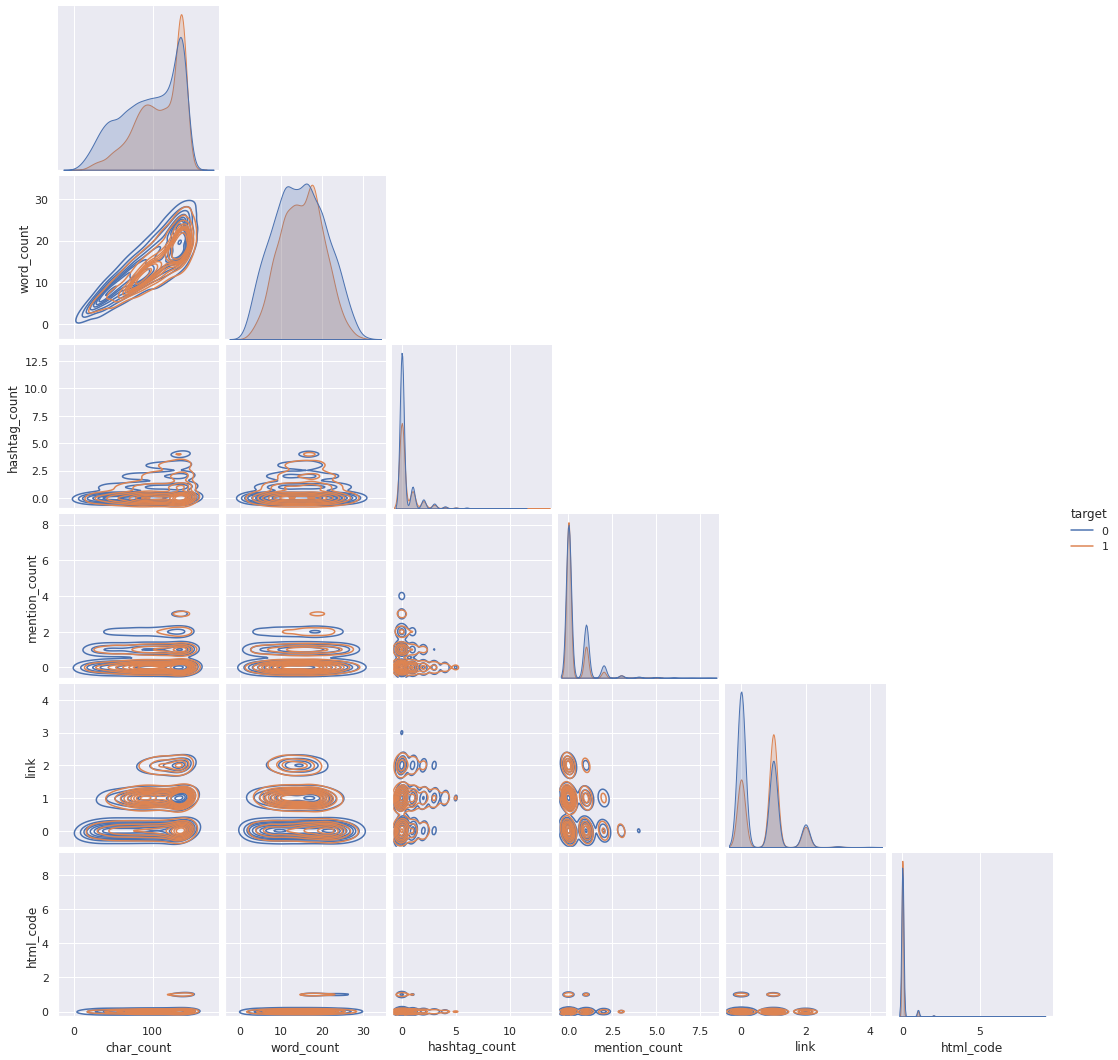

In [ ]:
stat_cols = ['char_count','word_count','hashtag_count','mention_count','link','html_code', 'target']
sns.pairplot(train[stat_cols], hue="target", kind="kde", corner=True)

# 5. Text cleaning

### 5.1 Normalizing and deleting unwanted characters

In [28]:
# OPTIONS : p.OPT.URL | p.OPT.MENTION | p.OPT.HASHTAG | p.OPT.RESERVED | p.OPT.EMOJI | p.OPT.SMILEY | p.OPT.NUMBER

def tweet_cleaner(text):
    p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.SMILEY, p.OPT.NUMBER,p.OPT.MENTION)
    return p.clean(text)

def delete_punctuation(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

def delete_words_with_numbers(text):
    text = re.sub(r'\w*\d\w*', '', text).strip()
    return text
    
def cleaner(text):
    text = text.lower()
    
    text = tweet_cleaner(text)
    text = delete_punctuation(text)
    text = delete_words_with_numbers(text)
    
    text = text.strip()
    return text

In [29]:
train.text = train.text.apply(lambda x: cleaner(x))
test.text = test.text.apply(lambda x: cleaner(x))

### 5.2 Delete stopwords using nltk corpus (optional)

In [30]:
def delete_stopword(text):

    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words_array = []
    joined_words = ''
    for w in words:
        if w not in stop_words:
            words_array.append(w)
            joined_words = ' '.join(words_array)
    return joined_words

In [31]:
# Possible to set condition to True but performance of MNB will be slighly worse
execute_delete_stopword_function = False

if execute_delete_stopword_function :
    train.text = train.text.apply(lambda x: delete_stopword(x))
    test.text = test.text.apply(lambda x: delete_stopword(x))

# 6. Create final dataset for training

### 6.1 Isolate tweet statistics

In [32]:
train_tweet_stat = train[['char_count','word_count','hashtag_count','mention_count','link','html_code']]
test_tweet_stat = test[['char_count','word_count','hashtag_count','mention_count','link','html_code']]

### 6.2 Convert tweets to a matrix of token counts

In [33]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train["text"])
test_vectors = count_vectorizer.transform(test["text"])

In [34]:
df_train = pd.DataFrame(train_vectors.todense())
df_test = pd.DataFrame(test_vectors.todense())

In [35]:
# tweet statistics don't improve MNB's performance so we won't use it in our model
add_tweet_statistics = False

if add_tweet_statistics:
    df_train = df_train.join(train_tweet_stat)
    df_test = df_test.join(test_tweet_stat)

# verification
assert df_train.shape[1] == df_test.shape[1]

# 7. Multinomial Naive Bayes

In [36]:
scores = {'acc': 'accuracy', 'f1': 'f1'}

mnb_clf = MultinomialNB()
scores = model_selection.cross_validate(mnb_clf, df_train, train["target"], cv=5, scoring=scores)

print('MultinomialNB :')
print('Accuracy :', "{:.2f}".format(scores['test_acc'].mean()))
print('F1 :', "{:.2f}".format(scores['test_f1'].mean()))

mnb_clf.fit(df_train, train["target"])

MultinomialNB :
Accuracy : 0.72
F1 : 0.67


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
#sample_submission["target"] = mnb_clf.predict(df_test)
#sample_submission.head()

# 8. BERT

In [ ]:
%%time

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 7.73 s, sys: 1.18 s, total: 8.91 s
Wall time: 9.5 s


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train["target"].values

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=32)

Epoch 1/3
191/191 [==============================] - 218s 1s/step - loss: 0.5079 - accuracy: 0.7604 - val_loss: 0.3876 - val_accuracy: 0.8319
Epoch 2/3
191/191 [==============================] - 207s 1s/step - loss: 0.3440 - accuracy: 0.8634 - val_loss: 0.3903 - val_accuracy: 0.8227
Epoch 3/3
191/191 [==============================] - 207s 1s/step - loss: 0.2894 - accuracy: 0.8860 - val_loss: 0.4012 - val_accuracy: 0.8280


In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [ ]:
sample_submission["target"] = (test_pred > 0.5).astype(int) 
sample_submission.to_csv("submission.csv", index=False)